# Bayesian AB testing

In [1]:
from dataclasses import dataclass
from typing import Dict, List, Union

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from scipy.stats import bernoulli, expon

- data class is a class that is designed to hold values
- They do not have any other methods
- data class store information that will be passed down to different types of programs

- typing is a library for type hints

In [2]:
# Setting the random seed
RANDOM_SEED = 4000
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

plotting_defaults = dict(bins=50, kind="hist", textsize=10)

In [3]:
# Defining the dataclass BetaPrior and BinomialData 
@dataclass
class BetaPrior:
    alpha: float
    beta: float

@dataclass
class BinomialData:
    trials: int
    successes: int

In [4]:
# Creating the model
class ConversionModelTwoVariant:
    # When we initialize the ConversionModel for two variants, it will take the betaprior as an input in the priors parameter
    def __init__(self,priors: BetaPrior):
        self.priors = priors
    # Defining create model that takes one parameter data (list). This data contains Binomial data in the list
    def create_model(self, data: List[BinomialData]) -> pm.Model:
        # Extracting a list to trials and successes separately
        trials = [d.trials for d in data]
        successes = [d.successes for d in data]

        # Create a model
        with pm.Model() as model:
            # Priors
            p = pm.Beta("p", alpha=self.priors.alpha , beta=self.priors.beta , shape=2)

            # Likelihood
            likelihood = pm.Binomial("likelihood", n=trials , p=p , shape=2, observed=successes)

            # Deterministic
            # This is just saying the treatment - Obseverd / Observed
            uplift = pm.Deterministic("uplift", p[1]/p[0] - 1)
        return model
    

In [5]:
weak_prior = ConversionModelTwoVariant(BetaPrior(alpha=10, beta=10))
strong_prior = ConversionModelTwoVariant(BetaPrior(alpha=1000, beta=1000))

In [6]:
with weak_prior.create_model(data=[BinomialData(1,1),BinomialData(1,1)]):
    weak_prior_predictive = pm.sample_prior_predictive(samples=1000,return_inferencedata=False)
with strong_prior.create_model(data=[BinomialData(1,1),BinomialData(1,1)]):
    strong_prior_predictive = pm.sample_prior_predictive(samples=1000,return_inferencedata=False)

Sampling: [likelihood, p]
Sampling: [likelihood, p]


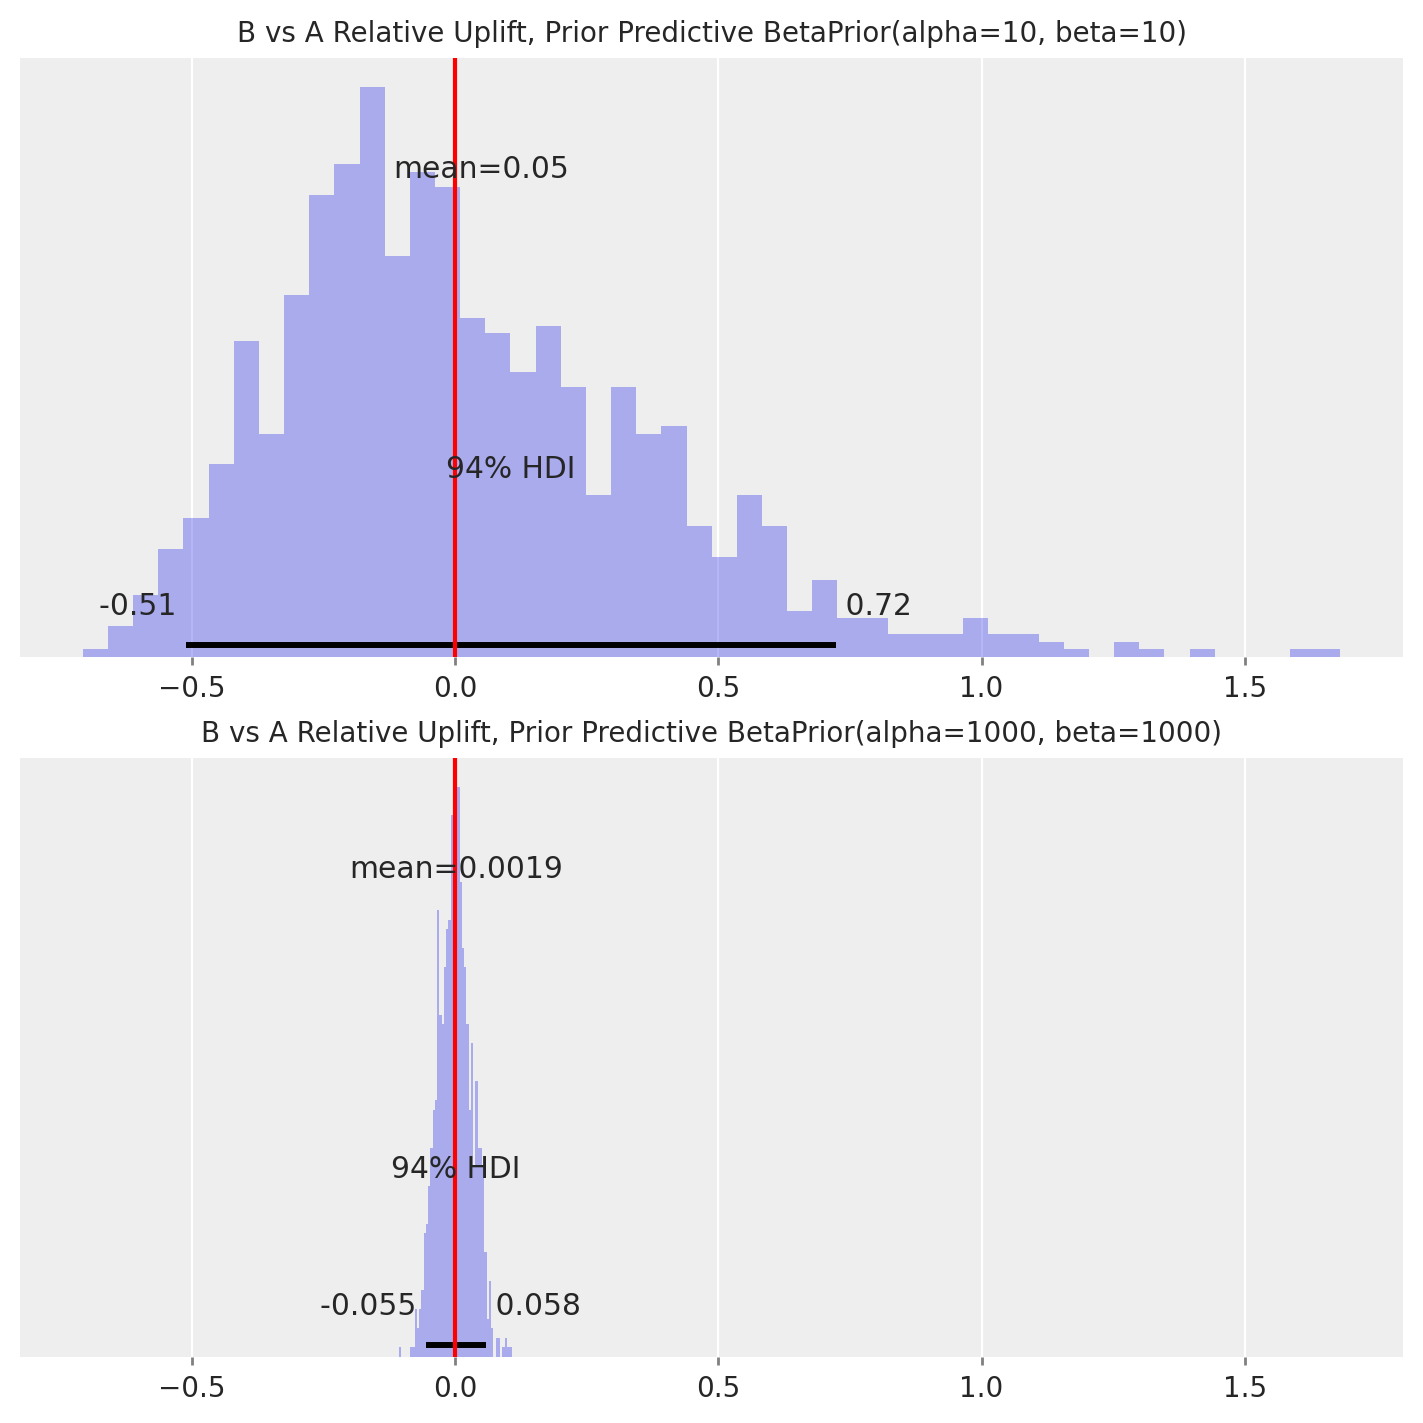

In [7]:
# Getting the figure
fig, axs = plt.subplots(2,1, figsize=(7,7), sharex=True)
az.plot_posterior(weak_prior_predictive["uplift"], ax=axs[0], **plotting_defaults)
axs[0].set_title(f"B vs A Relative Uplift, Prior Predictive {weak_prior.priors}", fontsize=10)
axs[0].axvline(x=0, color="red")
az.plot_posterior(strong_prior_predictive["uplift"], ax=axs[1], **plotting_defaults)
axs[1].set_title(f"B vs A Relative Uplift, Prior Predictive {strong_prior.priors}", fontsize=10)
axs[1].axvline(x=0, color="red")


Learnings:
* When chosing weak priors, the 94% HDI (High density interval) for the the uplift for B when compared to A is [-20% to 20%]
* When chosing strong priors, the 94% HDI (High density interval) for the uplift for B when compared to A is [-2% to 2%]

## Data

In [8]:
def generate_binomial_data(variants: List[str], true_rates: List[float], samples_per_variant: int = 10000) -> pd.DataFrame:
    # assign an empty dictionary
    data = {}

    # Run through each variant and its probability, sample the data (This is a real dataset)
    for variant, p in zip(variants, true_rates):
        data[variant] = bernoulli.rvs(p, size=samples_per_variant)

    # Aggregate the data and get the count and sum. Rename it to trials and successes
    agg = pd.DataFrame(data).aggregate(["count", "sum"]).rename(index={"count":"trials", "sum":"successes"})
    return(agg)

In [9]:
x = generate_binomial_data(["A", "B"], [0.23, 0.23])
x.shape

(2, 2)

In [10]:
def run_scenario_twovariant(variants: List[str], true_rates: List[float], samples_per_variant: int, weak_prior: BetaPrior, strong_prior: BetaPrior) -> None:
    # Gerenated will generate the data and aggregate for each variant
    generated = generate_binomial_data(variants, true_rates, samples_per_variant)

    # It will generate data based on the conversion rate in the generated
    # "**" unpacks the key-value in the dictionary
    data = [BinomialData(**generated[v].to_dict()) for v in variants]

    # Create two models 1. is based on Weak Prior and 2. is based on the strong prior
    with ConversionModelTwoVariant(priors=weak_prior).create_model(data):
        trace_weak = pm.sample(draws=5000)
    with ConversionModelTwoVariant(priors=strong_prior).create_model(data):
        trace_strong = pm.sample(draws=5000)

    true_rel_uplift = true_rates[1]/true_rates[0] - 1

    # Add the visualization code here
    fig, axs = plt.subplots(2,1, figsize  = (7,7),sharex=True)
    az.plot_posterior(trace_weak.posterior["uplift"], ax=axs[0], **plotting_defaults)
    axs[0].set_title(f"True Rel Uplift = {true_rel_uplift:.1%}, {weak_prior}", fontsize=10)
    axs[0].axvline(x=0, color="red")
    az.plot_posterior(trace_strong.posterior["uplift"], ax=axs[1], **plotting_defaults)
    axs[1].set_title(f"True Rel Uplift = {true_rel_uplift:.1%}, {strong_prior}", fontsize=10)
    axs[1].axvline(x=0, color="red")
    fig.suptitle("B vs. A Rel Uplift")
    return trace_weak, trace_strong


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 19 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


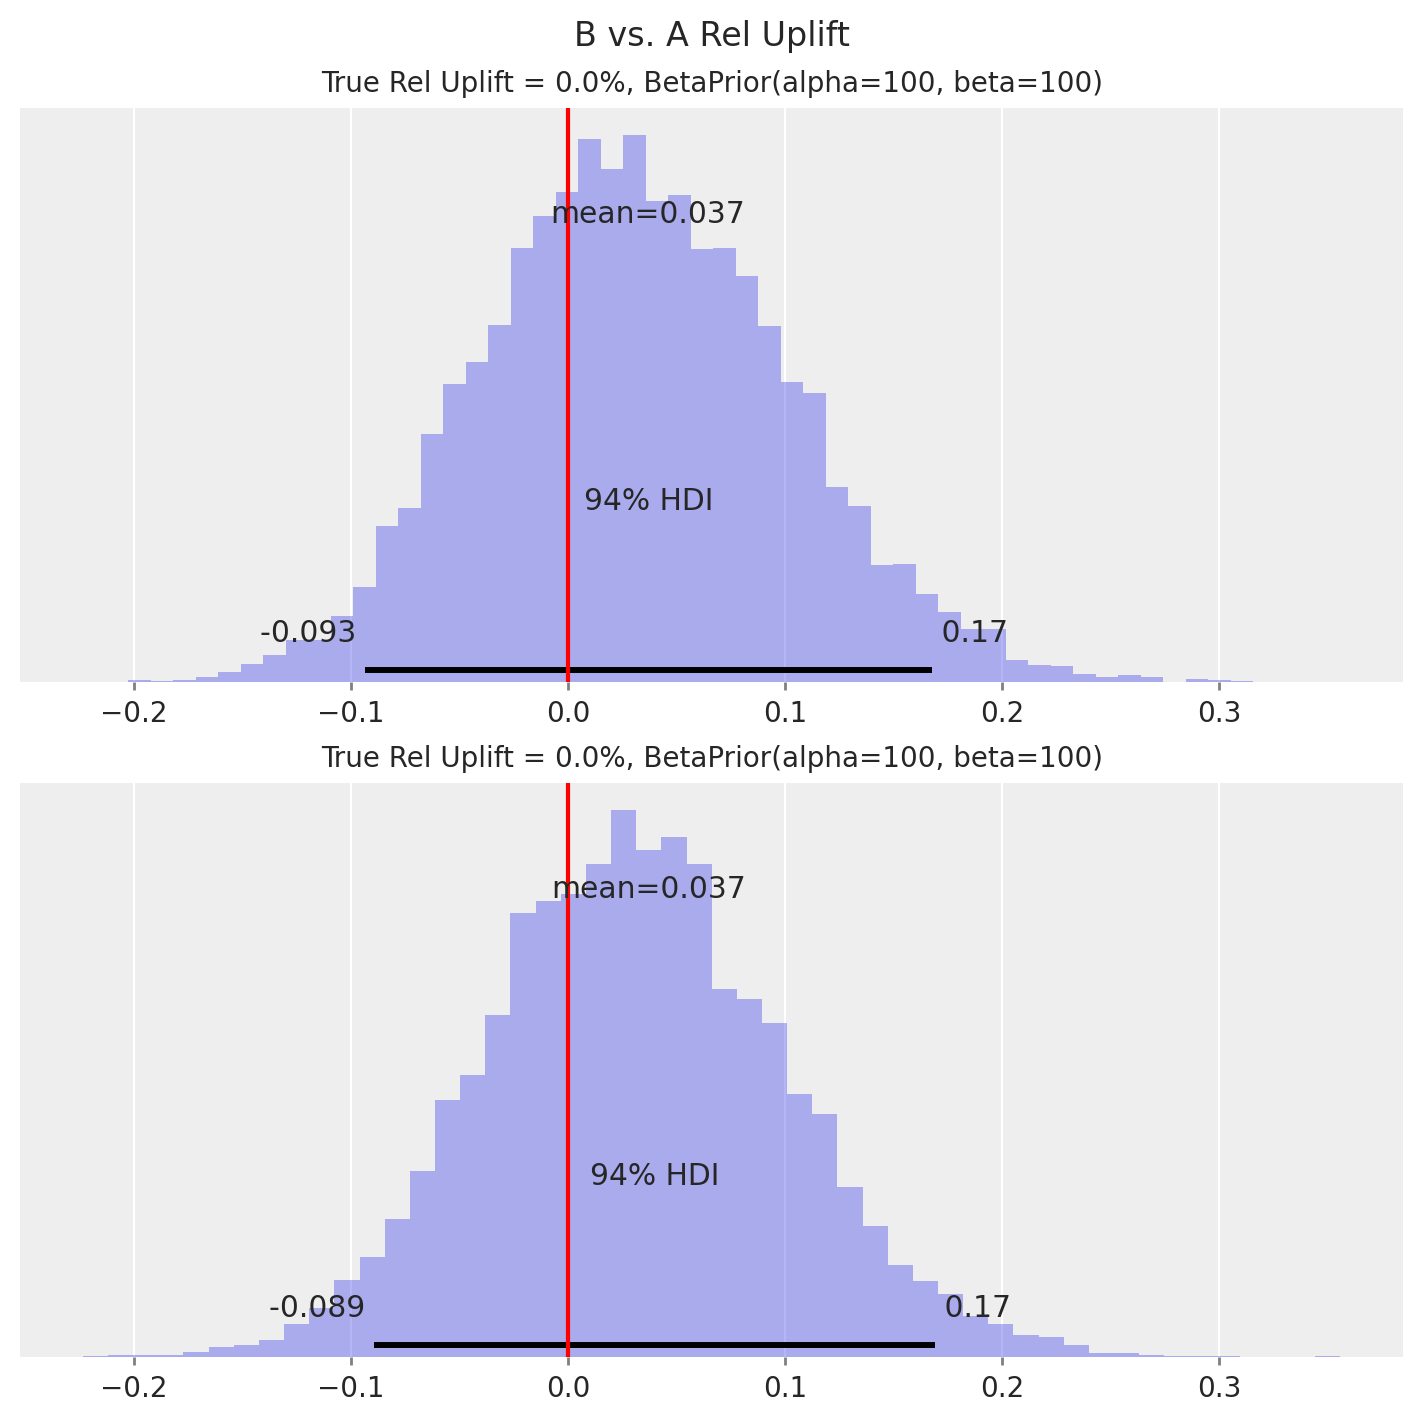

In [11]:
y = run_scenario_twovariant(
    variants=["A", "B"],
    true_rates=[0.23, 0.23],
    samples_per_variant=1000,
    weak_prior=BetaPrior(alpha=100, beta=100),
    strong_prior=BetaPrior(alpha=100, beta=100),
)

# Scenario 2 - Different underlying rates

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


(Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data,
 Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data)

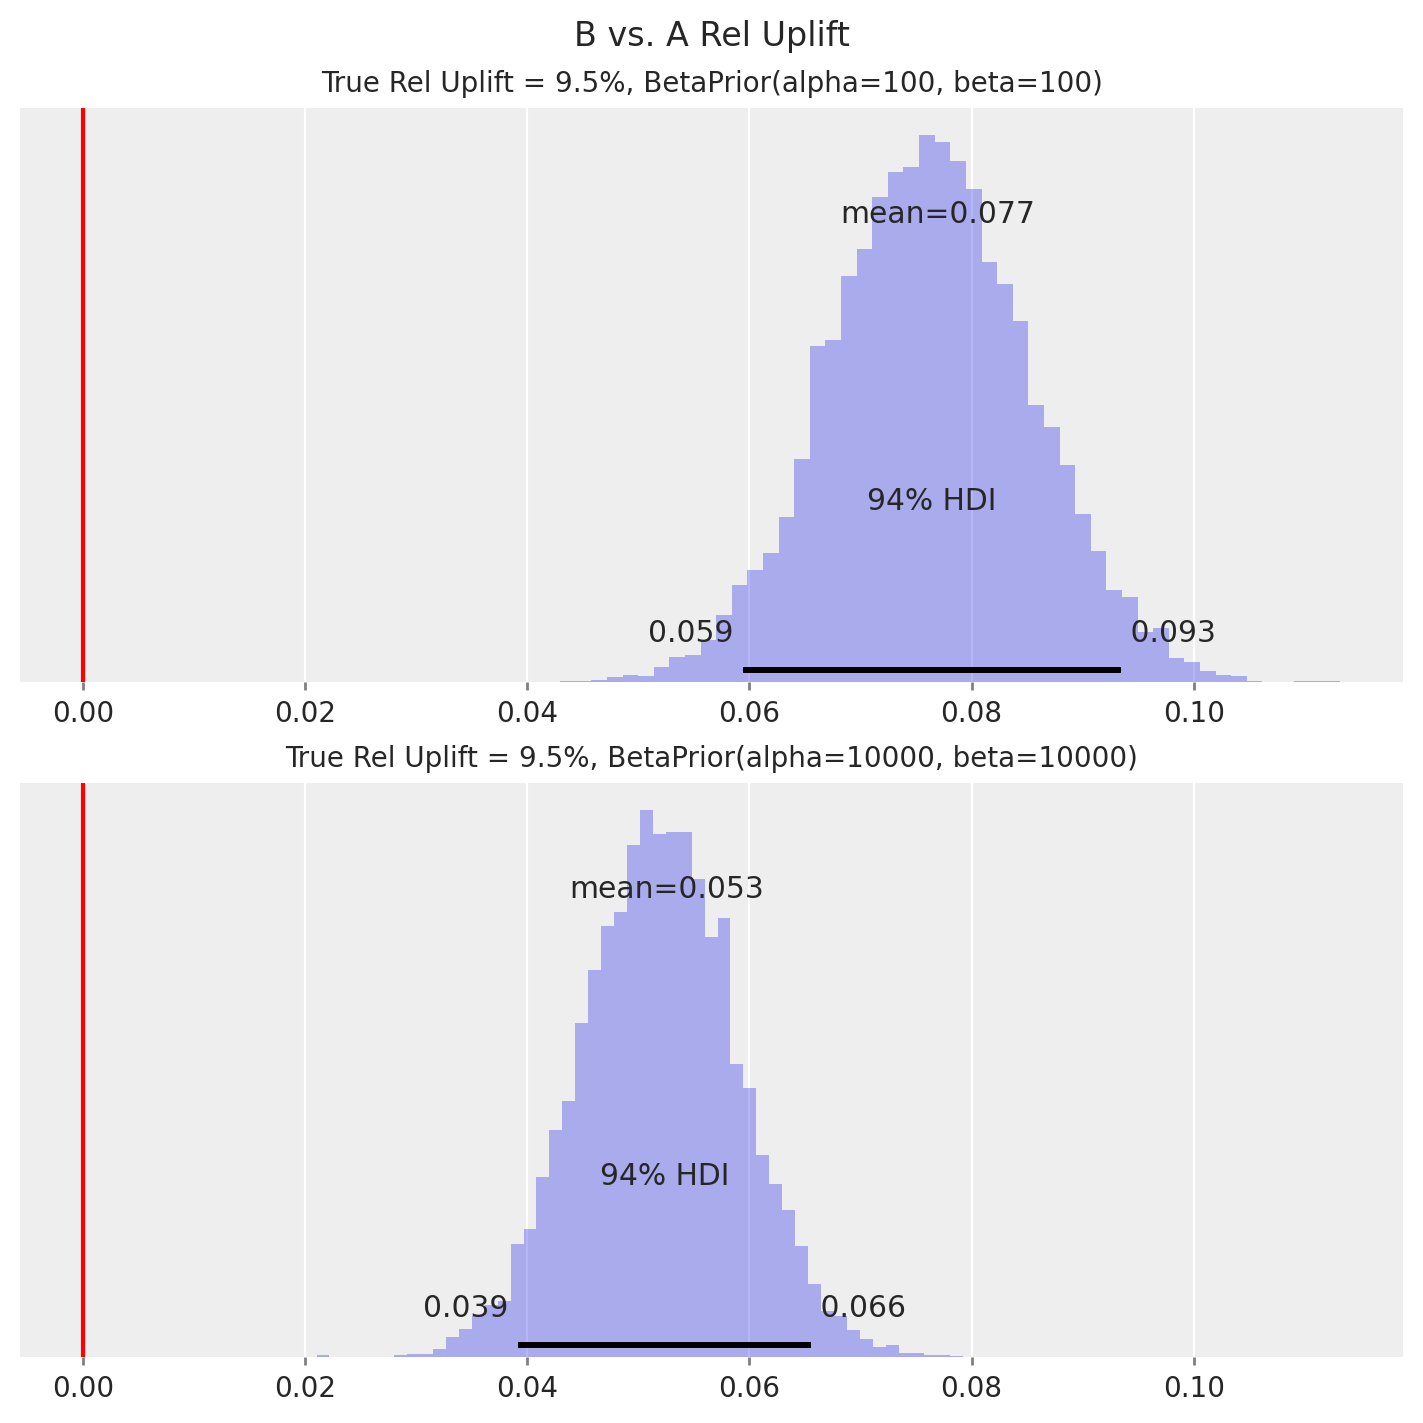

In [12]:
run_scenario_twovariant(
    variants=["A", "B"],
    true_rates=[0.21, 0.23],
    samples_per_variant=100000,
    weak_prior=BetaPrior(alpha=100, beta=100),
    strong_prior=BetaPrior(alpha=10000, beta=10000),
)

* In both cases, the prelative uplift suggests that the B has a higher conversion rate than A. The 94% High Density Interval is well above 0. The decision will be to roll out with variant B to all users.
* Notice that the strong prior is pulling the relative uplift closer to 0. So, outr central estimate is convervative. We will need much more data for inference to get cloer to the true relative uplift of 9.5%. 

# Generalizing to the Multi variate tests

In [13]:
class ConversionModel():
    def __init__(self, priors: BetaPrior):
        self.priors = priors

    def create_model(self, data: List[BinomialData], comparison_method) -> pm.Model:
        # Extracting the number of Variants from the data which contains a list of Binomial data
        num_variants = len(data)

        # Trials and successes
        trials = [d.trials for d in data]
        successes = [d.successes for d in data]

        # Creating the model
        with pm.Model() as model:
            p = pm.Beta("p", alpha=self.priors.alpha, beta=self.priors.beta, shape=num_variants)
            y = pm.Binomial("y", n= trials, p=p, observed=successes, shape=num_variants)

            reluplift = []

            for i in range(num_variants):
                if comparison_method == "compare_to_control":
                    comparison = p[0]
                elif comparison_method == "best_of_rest":
                    others = [p[j] for j in range(num_variants) if j != i]
                    if len(others)> 1:
                        comparison = pm.math.maximum(*others)
                    else:
                        comparison = others[0]
                else: 
                    raise ValueError(f"comparison method {comparison_method} not recognised.")

                # Deterministic
                reluplift.append(pm.Deterministic(f"reluplift_{i}", p[i]/comparison-1))
        
        return model

In [14]:
def run_scenario_bernoulli(variants: List[str],
                           true_rates: List[float],
                          samples_per_variant: int,
                          priors: BetaPrior,
                          comparison_method: str) -> az.InferenceData:
    generated = generate_binomial_data(variants, true_rates, samples_per_variant)
    data = [BinomialData(**generated[v].to_dict()) for v in variants]
    
    # Adding the trace to the model after creating the model
    with ConversionModel(priors).create_model(data=data, comparison_method=comparison_method):
        trace = pm.sample(draws=5000)

    # Creating visuals 
    n_plots = len(variants)
    fig, axs = plt.subplots(nrows=n_plots, ncols=1, figsize=(3*n_plots, 7), sharex= True)
    for i,variant in enumerate(variants):
        if i == 0 and comparison_method == "compare_to_control":
            axs[i].set_yticks([])
        else:
            az.plot_posterior(trace.posterior[f"reluplift_{i}"], ax=axs[i], **plotting_defaults)
        axs[i].set_title(f"Rel Uplift {variant}, True Rate = {true_rates[i]:.2%}", fontsize=10)
        axs[i].axvline(x=0, color="red")
    fig.suptitle(f"Method {comparison_method}, {priors}")

    return trace    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


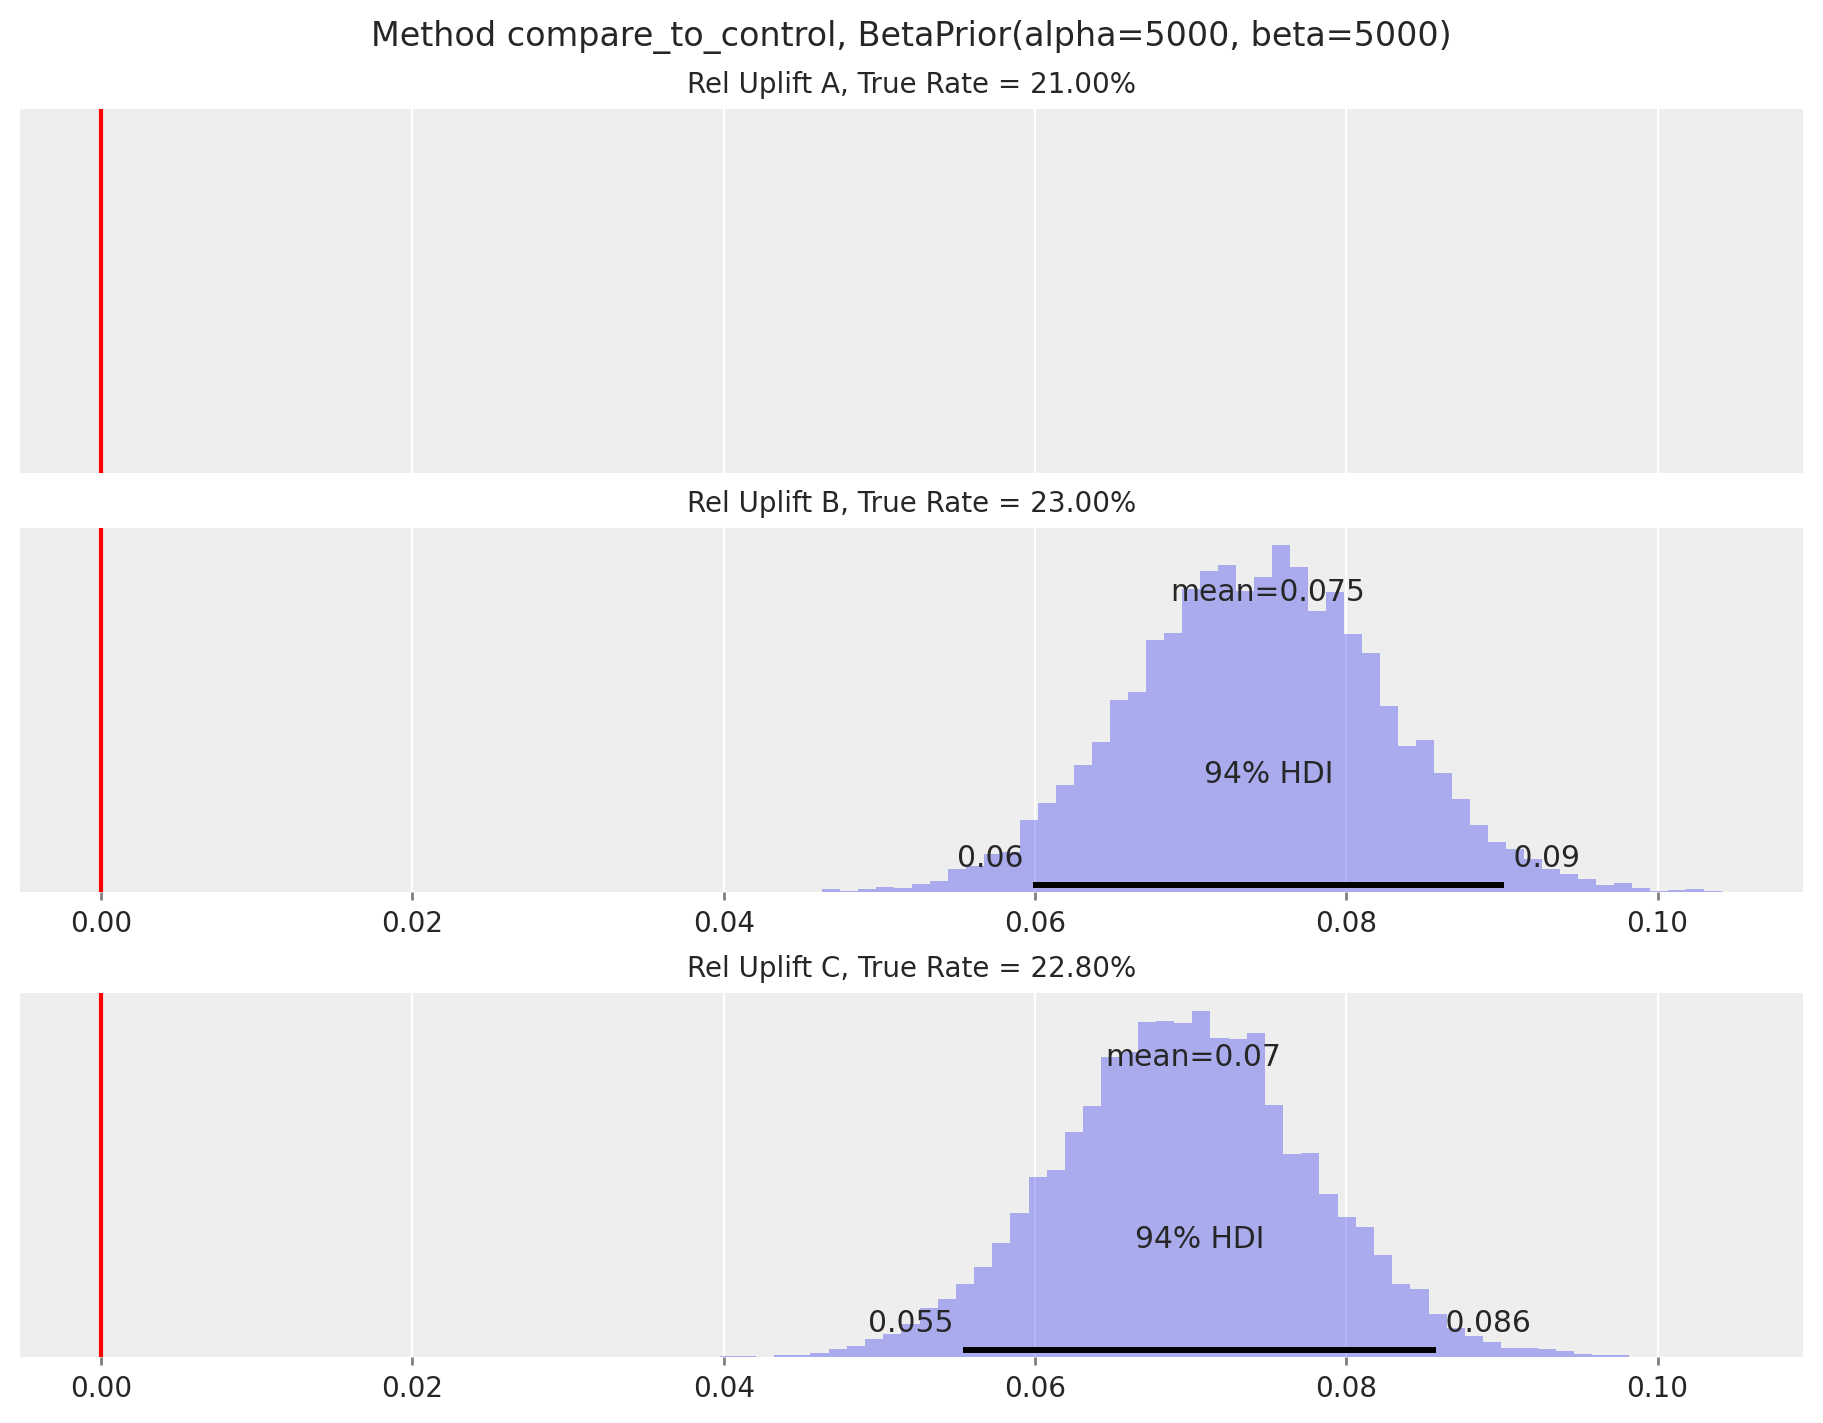

In [15]:
_ = run_scenario_bernoulli(
    variants=["A", "B", "C"],
    true_rates=[0.21, 0.23, 0.228],
    samples_per_variant=100000,
    priors=BetaPrior(alpha=5000, beta=5000),
    comparison_method="compare_to_control",
)

In [ ]:
_ = run_scenario_bernoulli(
    variants=["A", "B", "C"],
    true_rates=[0.21, 0.23, 0.228],
    samples_per_variant=100000,
    priors=BetaPrior(alpha=5000, beta=5000),
    comparison_method="best_of_rest",
)

Inferences:
* Uplift plot for A tells us that its a clear losed when compared to B and C. HDI is well below 0
* In the second plot when we measure best of the two, reluplift for B is compared against C and viceversa.
* Uplift plot of B and C tells us that there is no clear winner between two.